In [1]:
# Primary modules
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Other modules / functions
import pickle
import os
import matplotlib.gridspec as gridspec

# For inline plotting
%matplotlib inline
plt.ion()

In [2]:
# Import suftware (use development copy)
import sys
sys.path.append('../../suftware')

import suftware as sw

In [3]:
# Set default plotting style
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rc('text', usetex=True)
fontsize=7
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['hatch.linewidth'] = 1
mpl.rcParams['hatch.color'] = 'black'

figsize = [6.4, 9.0]
Processing Argus...
Legend!
Processing Beta...
Processing Bradford...
Processing Cauchy...
Processing ChiSquare...
Processing ExpPower...
Processing ExpWeibull...
Processing FoldedNormal...
Processing SkewNorm...
Processing Wald...
Processing WeibullMin...
Processing WrapCauchy...


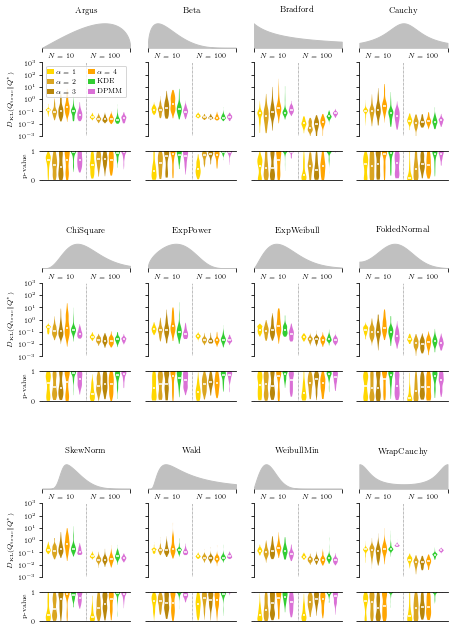

In [4]:
# Create figure
num_fig_rows = 3
num_fig_cols = 4
figsize=[1.6*num_fig_cols,3.0*num_fig_rows]
print('figsize = %s'%figsize)
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(5*num_fig_rows-1,1*num_fig_cols, top=.95, 
                       bottom=0.02, right=.98, left=.1, hspace=.5)

distribution_names = [
     'Argus',
     'Beta',
     'Bradford',
     'Cauchy',
     'ChiSquare',
     'ExpPower',
     'ExpWeibull',
     'FoldedNormal',
     'SkewNorm',
     'Wald',
     'WeibullMin',
     'WrapCauchy']
assert len(distribution_names) == num_fig_rows*num_fig_cols

# Iterate through distributions
sim_dir = 'simulations_final/fig2_figS3/'
for i, distribution_name in enumerate(distribution_names):
    print('Processing %s...'%distribution_name)
    
    # Clean dataframes
    df_klds = pd.DataFrame()
    df_pvs = pd.DataFrame()
    
    top_row = int(i/num_fig_cols)*5
    col = i%num_fig_cols
    
    # Load Geodesic distance
    klds_filename = '%s/df_KL_divergences_%s.pkl'%(sim_dir,distribution_name)
    tmp_df_klds = pickle.load(open(klds_filename,'rb'), encoding='latin1')
    
    # Load p-values
    pvals_filename = '%s/df_p_values_%s.pkl'%(sim_dir,distribution_name)
    tmp_df_p_values = pickle.load(open(pvals_filename,'rb'), encoding='latin1')
    
    # Change column names
    new_columns = []
    for N in [10,100]:
        for alpha in [1,2,3,4]:
            new_columns.append('%s $\\alpha=%d$ %d'%(distribution_name, alpha, N))
        new_columns.append('%s KDE %d'%(distribution_name, N))
        new_columns.append('%s DPMM %d'%(distribution_name, N))
    tmp_df_klds.columns = new_columns
    tmp_df_p_values.columns = new_columns
    
    # Concatenate dataframes
    df_klds = pd.concat([df_klds,tmp_df_klds],axis=1)
    df_pvs = pd.concat([df_pvs,tmp_df_p_values],axis=1)
    
    #
    # Plot Q_true
    #
    
    ax = plt.subplot(gs[top_row,col])
    
    dist = sw.SimulatedDensity(name=distribution_name)
    xs = np.linspace(dist.xmin,dist.xmax,1000)
    ys = dist.evaluate(xs)
    ax.set_ylim([0,1.2*max(ys)])
    ax.set_yticks([])
    ax.set_xlim([dist.xmin, dist.xmax])
    ax.set_xticks([dist.xmin, dist.xmax])
    ax.set_xticklabels([])
    ax.fill_between(xs,ys,0,color='silver')
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(distribution_name)
    ax.axhline(0,linestyle='--',color='k',linewidth=.5)
    
    #
    # Plot KL divergences
    #

    # Set axes
    ax = plt.subplot(gs[(top_row+1):(top_row+3),col])

    # Fix geometry of geodesic distance
    num_cols = len(df_klds.columns)
    klds_xs = np.arange(num_cols).astype(float)
    klds_xs += 2+1*np.floor(klds_xs/6)   

    # Set colors
    color_pairs = [
        ('$\\alpha=1$','gold'),
        ('$\\alpha=2$','goldenrod'), 
        ('$\\alpha=3$','darkgoldenrod'),
        ('$\\alpha=4$','orange'),
        ('KDE','limegreen'),
        ('DPMM','orchid')
    ]
    color_dict = dict(color_pairs)

    # Make violinplots
    colors = [c[1] for c in color_pairs]*4
    parts = ax.violinplot(np.log10(df_klds.T), 
                          positions=klds_xs, 
                          widths=.8, 
                          showmedians=True, 
                          showextrema=False);
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i%len(colors)])
        pc.set_alpha(1)
    parts['cmedians'].set_color('white')

    #Draw vertical lines
    vline_xs = 0.5*klds_xs[[5]] + 0.5*klds_xs[[6]]
    for vline_x in vline_xs:
        ax.axvline(vline_x, linestyle=':', color='k', linewidth=.5)

    # Show N=XXX along x-axis
    xlim = [min(klds_xs)-1, max(klds_xs)+1]
    ax.set_xlim(xlim)
    xtick_indices = np.arange(2,num_cols,6)
    xticks = klds_xs[xtick_indices]
    ax.set_xticks(xticks)
    ax.set_xticklabels(['$N=%s$'%df_klds.columns[i].split()[2] for i in xtick_indices])
    ax.xaxis.tick_top()
    ax.tick_params(axis='x', direction='in', length=0, width=0)

    # y-axis 
    yticks = list(range(-3,4))
    ylim = [min(yticks),max(yticks)]
    yticklabels = ['$10^{%d}$'%y for y in yticks]
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    for key, color in color_pairs:
        ax.plot([-10, -11], [1, 1], '-',color=color, label=key, linewidth=5)
    if col==0:
        ax.set_ylabel('$D_\mathrm{KL}(Q_\mathrm{true}\|Q^*)$')
    else:
        ax.set_yticklabels([])

    # Legend
    if col==0 and top_row==0:
        print('Legend!')
        ax.legend(loc='upper center', 
                  handlelength=.25,
                  ncol=2)
    
    # Other styling
    ax.spines['top'].set_visible(False) 
    ax.spines['bottom'].set_visible(False) 
    ax.spines['right'].set_visible(False) 

    #
    # Plot p-values
    #

    # Set axes
    ax = plt.subplot(gs[top_row+3,col])

    num_cols = len(df_pvs.columns)
    pvs_xs = klds_xs

    # Make violinplots
    colors = [c[1] for c in color_pairs]*4
    pvs = df_pvs.T
    m,n = pvs.shape
    noise = 0.05*(np.random.rand(m,n)-.5)
    parts = ax.violinplot(df_pvs.T + noise, 
                          positions=pvs_xs, 
                          widths=.8, 
                          showmedians=True, 
                          showextrema=False);
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(1)
    parts['cmedians'].set_color('white')

    # x-axis
    ax.set_xlim(xlim)
    ax.set_xticks([])
    for vline_x in vline_xs:
        ax.axvline(vline_x, linestyle=':', color='k', linewidth=.5)

    # y-axis
    ax.set_ylim([0,1])
    ax.set_yticks([0,1])
    if col==0:
        ax.set_ylabel('p-value')
    else:
        ax.set_yticklabels([])

    # Other styling
    ax.spines['top'].set_visible(True) 
    ax.spines['bottom'].set_visible(True) 
    ax.spines['right'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    

plt.show()
fig.savefig('figures/fig_S3.pdf')
    